In [1]:
from start import *
df = pd.read_csv('df_cleaned.csv', decimal='.')
cols_text=['review_comment_title', 'review_comment_message']
cols_cat=['product_category_name','review_score']
cols_num=['price','freight_value', 'order_item_id']
df_copy = df.copy()

C:\Users\boliv\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Meu computador não conseguia rodar os embeddings do Bert para esta base de dados, por isso eu rodei em outro computador e salvei os resultados nessas variavéis abaixo
import pickle
bert_result_message = pickle.load(open('bert_result_message.pickle', 'rb'))
bert_result_title = pickle.load(open('bert_result_title.pickle', 'rb'))

In [11]:
#Gera as colunas PCA que serão utilizadas no Ahmad, para o artigo esse código foi rodado 3 vezes, com o pca_k = 3, pca_k = 6, pca_k = 12
df_bert_pca_message = criando_coluna_PCA(df=df, modelo='bert', col='message', result_embbe=bert_result_message, pca_k=12)
df_bert_pca_title = criando_coluna_PCA(df=df_copy, modelo='bert', col='title', result_embbe=bert_result_title, pca_k=12)

In [12]:
#Seleciona apenas as variavéis numéricas
numeric_data_message = df_bert_pca_message.select_dtypes(include=['float64', 'float32'])
numeric_data_title = df_bert_pca_title.select_dtypes(include=['float64', 'float32'])
df_mixed = pd.concat([numeric_data_message, numeric_data_title], axis=1)
df_mixed = df_mixed.loc[:, ~df_mixed.columns.duplicated()]

In [13]:
#Gera a distância Ahmad para os dados mistos
dist_mtx_mt=distmix(data=df_mixed, method="ahmad", idnum=df_mixed.columns, idcat=cols_cat)

In [45]:
#Foram rodados experimentos alterando o n_clusters e o linkage, como mostrado no artigo
clustering_embedding = AgglomerativeClustering(metric='precomputed', linkage='average', n_clusters=12).fit_predict(dist_mtx_mt)

#APLICANDO SILHUETA EMBEDDIING
print(silhouette_score(X = dist_mtx_mt, labels=clustering_embedding, metric='precomputed'))

0.8680970939592307


In [46]:
#Mudar o tipo de linkage para testar mais
clustering_embedding = AgglomerativeClustering(metric='precomputed', linkage='complete', n_clusters=12).fit_predict(dist_mtx_mt)

#APLICANDO SILHUETA EMBEDDIING
print(silhouette_score(X = dist_mtx_mt, labels=clustering_embedding, metric='precomputed'))

0.8790906169827754


In [47]:
#Mudar o tipo de linkage para testar mais
clustering_embedding = AgglomerativeClustering(metric='precomputed', linkage='single', n_clusters=12).fit_predict(dist_mtx_mt)

#APLICANDO SILHUETA EMBEDDIING
print(silhouette_score(X = dist_mtx_mt, labels=clustering_embedding, metric='precomputed'))

0.899115830715356


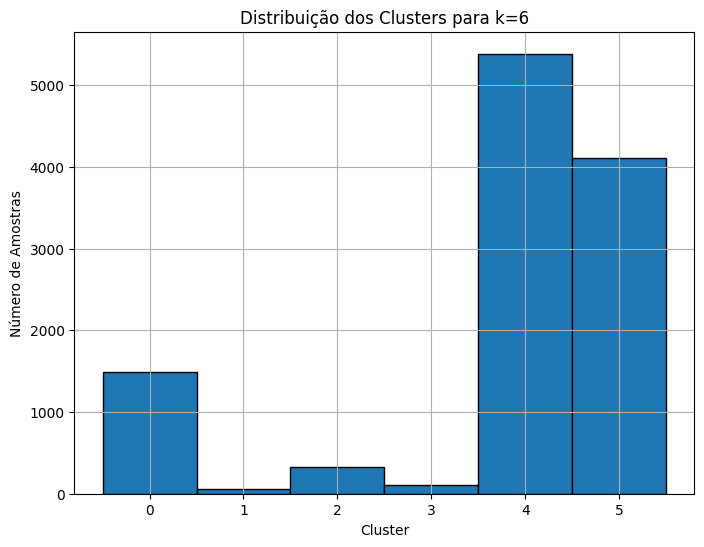

Pontuação média da Silhouette para k=6: 0.5146


In [8]:
import numpy as np
from sklearn.metrics import pairwise_distances, silhouette_score
from sklearn_extra.cluster import KMedoids
import matplotlib.pyplot as plt

# Defina o valor específico de k
k = 6  # Substitua este valor pelo valor de k que você deseja analisar

# Etapa 1: Cálculo da matriz de dissimilaridade
diss = pairwise_distances(dist_mtx_mt, metric="manhattan")

# Etapa 2: Ajustar o modelo KMedoids para o valor de k especificado
kmedoids = KMedoids(n_clusters=k, metric='precomputed', random_state=42).fit(diss)
labels = kmedoids.labels_

# Etapa 3: Calcular a pontuação da Silhouette
silhouette_avg = silhouette_score(diss, labels, metric='precomputed')

# Etapa 4: Plotar a matriz de dissimilaridade e os clusters
plt.figure(figsize=(8, 6))
plt.hist(labels, bins=np.arange(k+1)-0.5, edgecolor='black')
plt.title(f"Distribuição dos Clusters para k={k}")
plt.xlabel("Cluster")
plt.ylabel("Número de Amostras")
plt.grid(True)
plt.show()

# Exibir a pontuação da Silhouette
print(f"Pontuação média da Silhouette para k={k}: {silhouette_avg:.4f}")

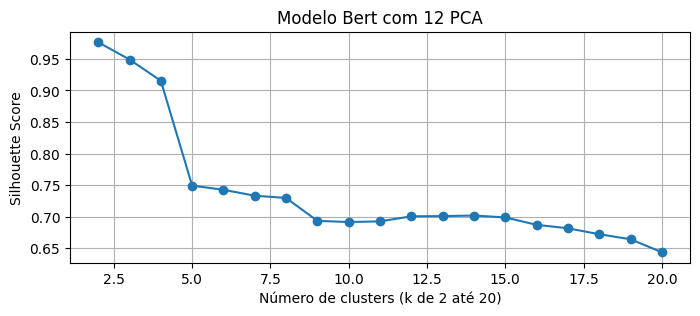

k=2, Silhouette Score=0.9765
k=3, Silhouette Score=0.9490
k=4, Silhouette Score=0.9153
k=5, Silhouette Score=0.7491
k=6, Silhouette Score=0.7426
k=7, Silhouette Score=0.7332
k=8, Silhouette Score=0.7296
k=9, Silhouette Score=0.6933
k=10, Silhouette Score=0.6915
k=11, Silhouette Score=0.6925
k=12, Silhouette Score=0.7005
k=13, Silhouette Score=0.7009
k=14, Silhouette Score=0.7017
k=15, Silhouette Score=0.6988
k=16, Silhouette Score=0.6871
k=17, Silhouette Score=0.6815
k=18, Silhouette Score=0.6721
k=19, Silhouette Score=0.6641
k=20, Silhouette Score=0.6436


In [15]:
import numpy as np
from sklearn.metrics import pairwise_distances, silhouette_score
from sklearn_extra.cluster import KMedoids
import matplotlib.pyplot as plt

# Etapa 1: Cálculo da matriz de dissimilaridade
diss = pairwise_distances(dist_mtx_mt, metric="cosine")

# Definir o intervalo de valores de k
kmin = 2
kmax = 20
silhouette_scores = []
k_range = range(kmin, kmax+1)

# Etapa 2: Iterar sobre diferentes valores de k e calcular a pontuação da Silhouette
for k in k_range:
    kmedoids = KMedoids(n_clusters=k, metric='precomputed', random_state=42).fit(diss)
    labels = kmedoids.labels_
    silhouette_avg = silhouette_score(diss, labels, metric='precomputed')
    silhouette_scores.append(silhouette_avg)

# Etapa 3: Plotar o gráfico da Silhouette em função de k
plt.figure(figsize=(16, 6))
plt.plot(k_range, silhouette_scores, marker='o')
plt.title("Modelo Bert PCA")
plt.xlabel("Número de clusters (k de 2 até 20)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

# Exibir as pontuações da Silhouette para cada valor de k
for k, score in zip(k_range, silhouette_scores):
    print(f"k={k}, Silhouette Score={score:.4f}")